### LeNET
LeNet-5는 32x32 크기의 흑백 이미지에서 학습된 7 layer Convolutional Neural Network 이다.


[Conv(C1) - Subsampling(S2) - Conv(C3) - Subsampling(S4) - Conv(C5) - FC - FC]



<img src = 'https://miro.medium.com/v2/resize:fit:1100/format:webp/1*AwJZkWLKabIicUPzSN6KCg.png'>




### 데이터 가져오기

<a href='https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset'>Face Mask Detection</a> 데이터셋은 약 12,000개의 이미지로 구성된 데이터셋입니다. 이 데이터셋은 얼굴 영역에 마스크를 착용한 경우와 착용하지 않은 경우를 포함하고 있습니다. Face Mask Detection은 주로 컴퓨터 비전 및 인공지능 알고리즘을 개발하고 테스트하는 데 사용될 수 있습니다.

데이터셋에는 다음과 같은 내용이 포함될 수 있습니다:

이미지: 얼굴 영역에 대한 이미지가 포함되어 있습니다. 각 이미지는 마스크를 착용한 경우와 착용하지 않은 경우로 분류될 수 있습니다.

레이블: 각 이미지에 대한 레이블 정보가 제공됩니다. 마스크를 착용한 경우와 착용하지 않은 경우로 레이블링되어 있습니다.

In [24]:
base_url = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/ML_DL_STUDY/deep_learning/'

In [13]:
import zipfile

# zip 파일 압출 풀기
content_zip = zipfile.ZipFile(base_url+'data/Mask.zip')
content_zip.extractall(base_url+'data/')
content_zip.close()

In [25]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
import tensorflow as tf
from tensorflow.keras import Sequential, models, layers
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [27]:
path = base_url+'data/Face Mask Dataset/'

dataset = {
    'image_path' : [],
    'mask_status' : [],
    'where' : []
}

In [28]:
for where in os.listdir(path): # Test, Train, Validation 폴더 존재
  print('Where --> : ', where)
  for status in os.listdir(path+where): # Withoutmask, Withmask 폴더 존재
    print('\tStatus --> : ',status)
    for image in glob.glob(path+where+'/'+status+'/'+'*.png'):
      dataset['image_path'].append(image)
      dataset['mask_status'].append(status)
      dataset['where'].append(where)

Where --> :  Test
	Status --> :  WithMask
	Status --> :  WithoutMask
Where --> :  Train
	Status --> :  WithMask
	Status --> :  WithoutMask
Where --> :  Validation
	Status --> :  WithMask
	Status --> :  WithoutMask


In [29]:
dataset = pd.DataFrame(dataset)
dataset.head()

,image_path,mask_status,where
0,/content/drive/MyDrive/Colab Notebooks/Deep Le...,WithMask,Test
1,/content/drive/MyDrive/Colab Notebooks/Deep Le...,WithMask,Test
2,/content/drive/MyDrive/Colab Notebooks/Deep Le...,WithMask,Test
3,/content/drive/MyDrive/Colab Notebooks/Deep Le...,WithMask,Test
4,/content/drive/MyDrive/Colab Notebooks/Deep Le...,WithMask,Test


### EDA

With Mask 5909
Without Mask 5883


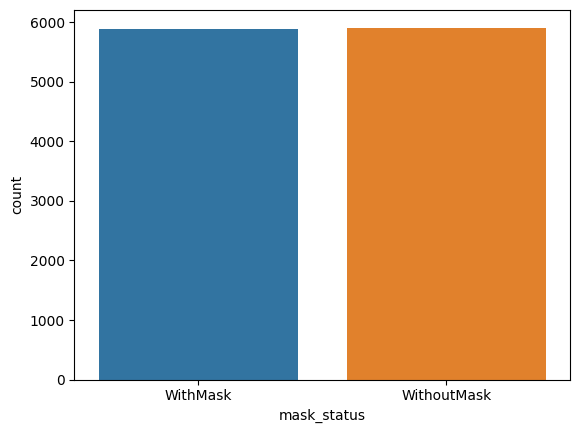

In [30]:
print('With Mask', dataset.value_counts('mask_status')[0])
print('Without Mask', dataset.value_counts('mask_status')[1])

sns.countplot(x=dataset['mask_status']);

In [32]:
import cv2

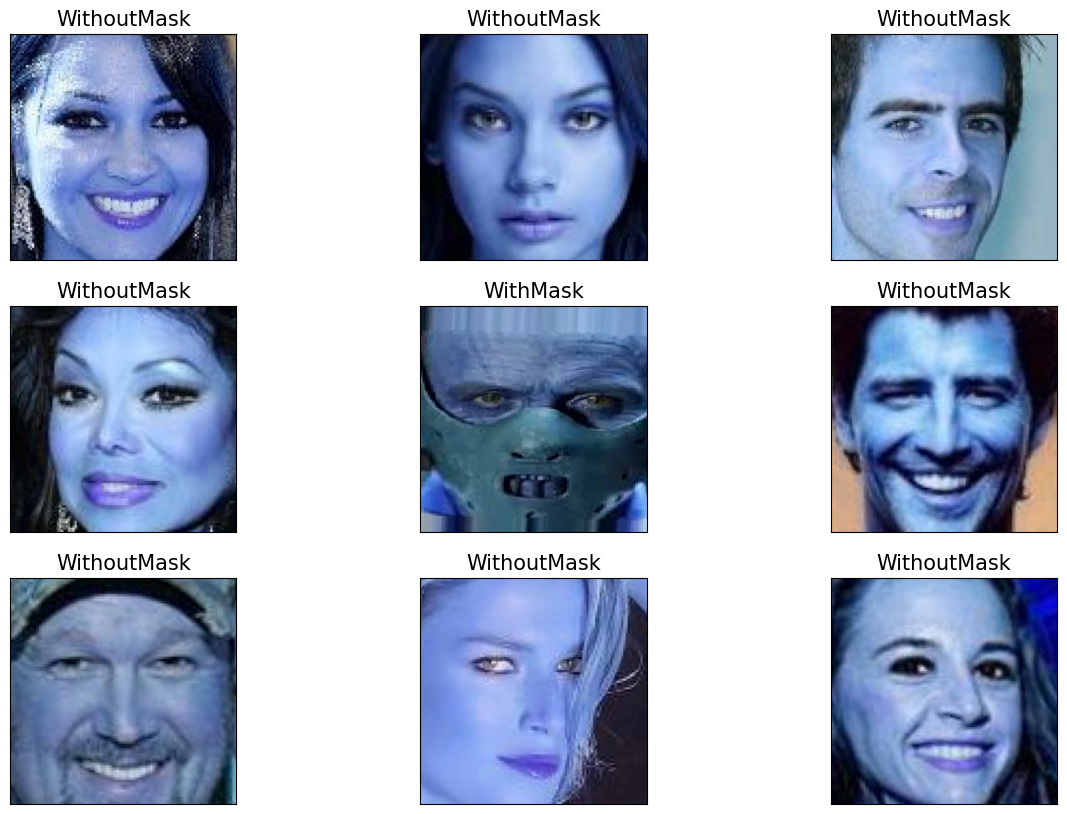

In [36]:
plt.figure(figsize=(15,10))

for i in range(9):
  random = np.random.randint(1, len(dataset))
  plt.subplot(3, 3 , i+1 )
  plt.imshow(cv2.imread(dataset.loc[random, 'image_path']))
  plt.title(dataset.loc[random,'mask_status'],size = 15)
  plt.xticks([])
  plt.yticks([])


plt.show()

In [37]:
train_df = dataset[dataset['where'] == 'Train']
test_df = dataset[dataset['where'] == 'Test']
validation_df = dataset[dataset['where'] == 'Validation']

train_df.head()


,image_path,mask_status,where
992,/content/drive/MyDrive/Colab Notebooks/Deep Le...,WithMask,Train
993,/content/drive/MyDrive/Colab Notebooks/Deep Le...,WithMask,Train
994,/content/drive/MyDrive/Colab Notebooks/Deep Le...,WithMask,Train
995,/content/drive/MyDrive/Colab Notebooks/Deep Le...,WithMask,Train
996,/content/drive/MyDrive/Colab Notebooks/Deep Le...,WithMask,Train


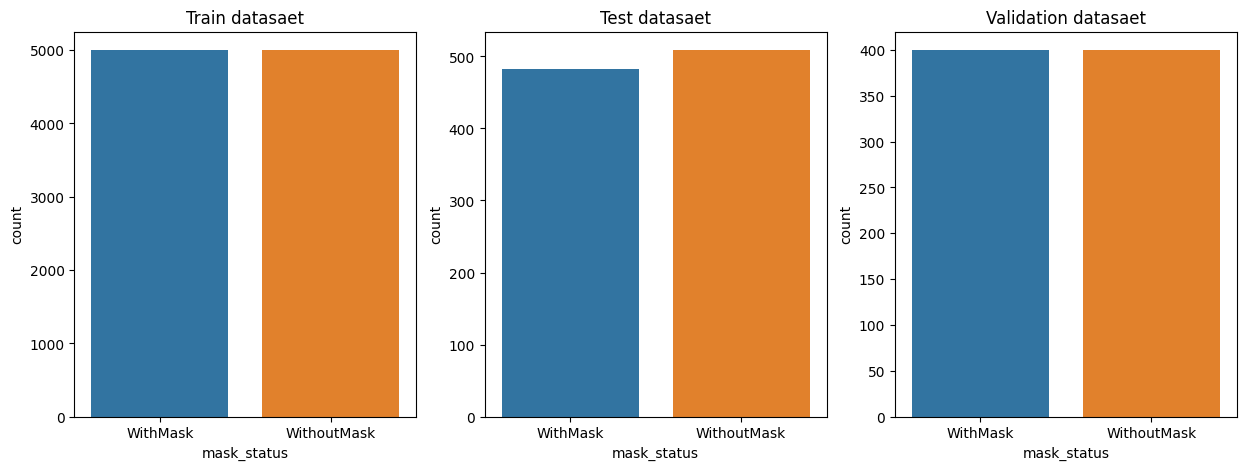

In [39]:
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
sns.countplot(x=train_df['mask_status'])
plt.title('Train datasaet')
plt.subplot(1,3,2)
sns.countplot(x=test_df['mask_status'])
plt.title('Test datasaet')

plt.subplot(1,3,3)
sns.countplot(x=validation_df['mask_status'])
plt.title('Validation datasaet')

plt.show()


### 데이터 전처리

In [41]:
train_df.reset_index(drop=True, inplace = True)
train_df.head()

,image_path,mask_status,where
0,/content/drive/MyDrive/Colab Notebooks/Deep Le...,WithMask,Train
1,/content/drive/MyDrive/Colab Notebooks/Deep Le...,WithMask,Train
2,/content/drive/MyDrive/Colab Notebooks/Deep Le...,WithMask,Train
3,/content/drive/MyDrive/Colab Notebooks/Deep Le...,WithMask,Train
4,/content/drive/MyDrive/Colab Notebooks/Deep Le...,WithMask,Train


In [42]:
data = []
image_size = 150

for i in range(len(train_df)):
  img_array = cv2.imread(train_df['image_path'][i], cv2.IMREAD_GRAYSCALE)
  new_image_arr = cv2.resize(img_array, (image_size, image_size))

  if train_df['mask_status'][i] == 'WithMask':
    data.append([new_image_arr, 1]) #[[image], label] 형태

  else:
    data.append([new_image_arr, 0])



In [43]:
data[0] # [[이미지 픽셀 값], 마스크 라벨]

[array([[238, 238, 238, ..., 199, 199, 199],
        [238, 238, 238, ..., 197, 197, 197],
        [237, 237, 238, ..., 194, 194, 195],
        ...,
        [236, 236, 236, ..., 151, 151, 152],
        [235, 235, 235, ..., 151, 152, 152],
        [235, 235, 235, ..., 151, 152, 152]], dtype=uint8),
 1]

In [44]:
# 데이터 섞기
np.random.shuffle(data)
data[0]

[array([[202, 202, 202, ...,  79,  77,  85],
        [202, 202, 202, ...,  79,  71,  73],
        [202, 202, 202, ...,  79,  67,  65],
        ...,
        [111,  98,  93, ..., 131, 122, 140],
        [106,  99,  92, ..., 132, 119, 143],
        [106,  99,  90, ..., 132, 124, 147]], dtype=uint8),
 0]

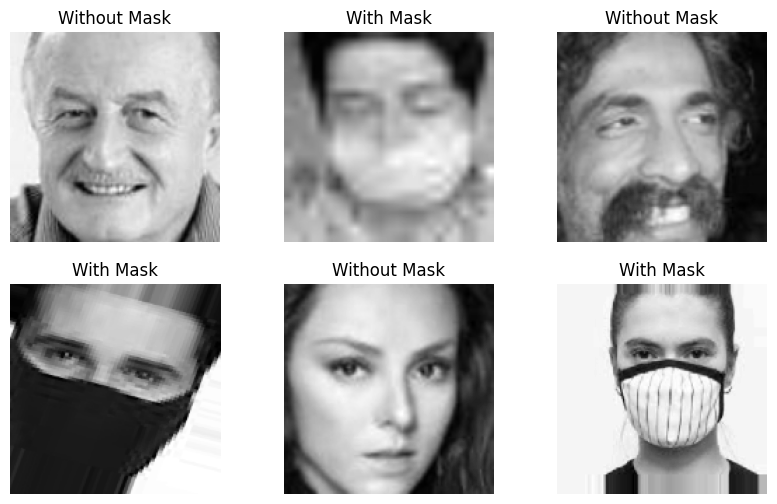

In [46]:
fig, ax = plt.subplots(2, 3, figsize=(10,6))

for row in range(2):
  for col in range(3):
    image_index = row * 100 + col

    ax[row, col].axis('off')
    ax[row, col].imshow(data[image_index][0], cmap = 'gray')

    if data[image_index][1] == 0:
      ax[row, col].set_title('Without Mask')
    else:
      ax[row, col].set_title('With Mask')



In [49]:
X = []
y = []

for image in data:
  X.append(image[0])
  y.append(image[1])

X = np.array(X)
y = np.array(y)

### Train 데이터, Test 데이터 나누기

In [50]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = 13)

### LeNET CNN

In [56]:
model = models.Sequential([
    layers.Conv2D(32, kernel_size = (5,5), strides = (1,1), padding= 'same', activation='relu', input_shape = (150, 150, 1)),# 150*150 크기의 흑백 이미지
    layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)),
    layers.Conv2D(64, (2,2), activation = 'relu', padding = 'same'),
    layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(1000, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
])

In [59]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 150, 150, 32)      832       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 64)        8256      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 37, 37, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 87616)             0

In [60]:
model.compile(optimizer = 'adam', loss = tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [67]:
X_train = X_train.reshape(-1, 150, 150, 1)
X_val = X_val.reshape(-1, 150, 150, 1)

### 모델 학습

In [70]:
history = model.fit(X_train, y_train, epochs = 4, batch_size = 32)

Epoch 1/4
250/250 [==============================] - 11s 42ms/step - loss: 0.0454 - accuracy: 0.9843
Epoch 2/4
250/250 [==============================] - 11s 42ms/step - loss: 0.0110 - accuracy: 0.9964
Epoch 3/4
250/250 [==============================] - 11s 44ms/step - loss: 0.0145 - accuracy: 0.9952
Epoch 4/4
250/250 [==============================] - 10s 41ms/step - loss: 0.0132 - accuracy: 0.9962


In [72]:
model.evaluate(X_val, y_val)

63/63 [==============================] - 1s 8ms/step - loss: 0.1449 - accuracy: 0.9710


[0.14494413137435913, 0.9710000157356262]

### 모델 평가

실제 마스크를 쓰지 않은 사람들 조다 마스크를 쓴 사람들을 구별하는 성능이 더 높음

In [75]:
prediction = (model.predict(X_val) > 0.5).astype('int32')

print(classification_report(y_val, prediction))
print(confusion_matrix(y_val, prediction))

63/63 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1007
           1       0.98      0.96      0.97       993

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000

[[986  21]
 [ 37 956]]


In [79]:
wrong_result = []

for n in range(0, len(y_val)):
  if prediction[n] != y_val[n]: # 예측 결과가 다르면
      wrong_result.append(n)

len(wrong_result) # 예측 실패 한 데이터 개수

58

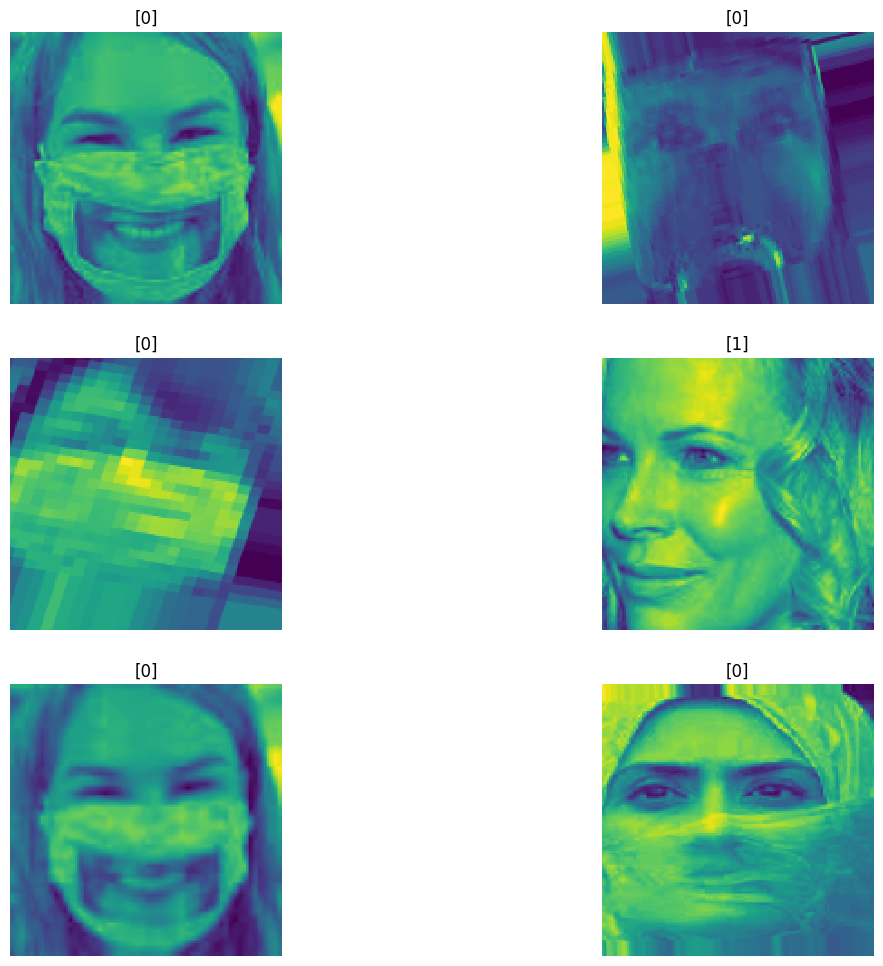

In [84]:
import random

samples = random.choices(population = wrong_result, k = 6) # 6개만 확인해보자

plt.figure(figsize=(14, 12))

for idx, n in enumerate(samples):
  plt.subplot(3,2, idx+1)
  plt.imshow(X_val[n].reshape(150, 150), interpolation='nearest')
  plt.title(prediction[n])
  plt.axis('off')

plt.show()